In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, LSTM
from tensorflow.keras.optimizers import Adam

# I. Import Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/DS301 Group project/milestone 3/processed_data.csv')

Mounted at /content/drive


In [ ]:
print(df[['Price', 'FederalFundsRate', 'InflationRate', 'GDP', 'Debt', 'UnemploymentRate']].dtypes)

Price               float64
FederalFundsRate    float64
InflationRate       float64
GDP                 float64
Debt                float64
UnemploymentRate    float64
dtype: object


In [ ]:
# Verify the conversion
print(df['Price'].dtype)


float64


In [ ]:
df.head()

Date    Price     Open     High      Low  FederalFundsRate  \
0  2019-05-15  2850.96  2820.38  2858.68  2815.08          2.366629   
1  2019-05-14  2834.41  2820.12  2852.54  2820.12          2.402815   
2  2019-05-13  2811.87  2840.19  2840.19  2801.43          2.381258   
3  2019-05-10  2881.40  2863.10  2891.31  2825.39          2.376061   
4  2019-05-09  2870.72  2859.84  2875.97  2836.40          2.390029   

   InflationRate           GDP          Debt  UnemploymentRate  
0     256.456712  21757.125635  2.183812e+07          3.285329  
1     256.442691  20893.626769  2.190574e+07          3.296204  
2     252.962056  21700.177739  2.188999e+07          3.306455  
3     256.289091  21109.954939  2.182879e+07          3.286604  
4     252.804759  21331.283022  2.206873e+07          3.319570

In [ ]:
df.tail()

Date  Price   Open   High    Low  FederalFundsRate  InflationRate  \
9930  1980-01-01  107.9  107.9  107.9  107.9         13.791702      78.318646   
9931  1979-12-31  107.9  107.9  108.5  107.3         13.699635      76.804828   
9932  1979-12-28  107.8  107.8  108.6  107.2         13.727211      77.724175   
9933  1979-12-27  108.0  108.0  108.5  107.1         13.841090      77.360706   
9934  1979-12-26  107.8  107.8  108.4  107.1         13.775313      76.151579   

              GDP           Debt  UnemploymentRate  
9930  2763.589448  874773.986019          5.272869  
9931  2723.121497  853938.951105          4.896666  
9932  2683.384122  848089.557613          4.923873  
9933  2695.913835  843986.628812          4.863894  
9934  2717.040428  837171.225553          4.906665

# II. Preprocessing

In [ ]:
# Data Preprocessing
# Feature Engineering: Apply log transformation to 'GDP' and 'Debt'
# Apply a logarithmic transformation to 'GDP' and 'Debt' before scaling. This helps in managing the scale differences between features.
# GDP and Debt are in million
df['GDP'] = np.log1p(df['GDP'])
df['Debt'] = np.log1p(df['Debt'])

# Drop 'Open', 'High', 'Low'
features = df[['FederalFundsRate', 'InflationRate', 'GDP', 'Debt', 'UnemploymentRate']]
target = df['Price']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
scaled_features

array([[-0.57953774,  1.72825149,  1.55359107,  1.53756893, -1.46972733],
       [-0.57064327,  1.7279719 ,  1.48286381,  1.54102535, -1.46275229],
       [-0.57594183,  1.65856807,  1.54901379,  1.54022102, -1.45617838],
       ...,
       [ 2.21290873, -1.83567419, -2.10114253, -2.09389788, -0.41887112],
       [ 2.24090023, -1.84292177, -2.09300921, -2.09931931, -0.45733745],
       [ 2.22473223, -1.86703175, -2.07938066, -2.1083834 , -0.42990744]])

# III. Build Models

In [ ]:
# Parameters
sequence_length = 5  # use 5 days of past data to predict the next day
features_dim = df[['FederalFundsRate', 'InflationRate', 'GDP', 'Debt', 'UnemploymentRate']].shape[1]  # number of economic features
head_size = 64
num_heads = 4
ff_dim = 256
dropout_rate = 0.1
batch_size = 64
epochs = 100

# Convert series to supervised format
def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df['Price'].shift(-i))
        if i == 0:
            names += [('Price(t)')]
        else:
            names += [('Price(t+%d)' % i)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

In [ ]:
# Define supervised data
supervised = series_to_supervised(pd.concat((df[['Price']], pd.DataFrame(scaled_features, columns=features.columns)), axis=1), n_in=sequence_length)

# Calculate the total number of columns for the time steps
n_obs = sequence_length * features_dim

X, y = supervised.values[:, :n_obs], supervised.values[:, -features_dim]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## a. Transformer Model

In [ ]:
# Reshape input to be 3D [samples, timesteps, features] for the Transformer
X_train = X_train.reshape((X_train.shape[0], sequence_length, features_dim))
X_test = X_test.reshape((X_test.shape[0], sequence_length, features_dim))

# Transformer Encoder definition
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(attn_output)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + inputs

# Function to build the Transformer model
def build_transformer_model(learning_rate=0.001, dropout_rate=0.1):
    input_layer = Input(shape=(sequence_length, features_dim))
    x = transformer_encoder(input_layer, head_size=64, num_heads=4, ff_dim=256, dropout=dropout_rate)
    x = GlobalAveragePooling1D()(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Hyperparameter Tuning
learning_rates = [0.0001, 0.001, 0.01]
dropout_rates = [0, 0.1, 0.2]
best_score = np.inf
best_params = {}

for lr in learning_rates:
    for dr in dropout_rates:
        model = build_transformer_model(learning_rate=lr, dropout_rate=dr)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
        y_pred = model.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE

        print(f"LR: {lr}, DR: {dr}, Test RMSE: {score}")

        if score < best_score:
            best_score = score
            best_params = {'learning_rate': lr, 'dropout_rate': dr}

print("Best Score (RMSE):", best_score)
print("Best Parameters:", best_params)


Epoch 1/100
125/125 [==============================] - 5s 6ms/step - loss: 188556.2969
Epoch 2/100
125/125 [==============================] - 1s 5ms/step - loss: 174547.0156
Epoch 3/100
125/125 [==============================] - 1s 5ms/step - loss: 160579.4375
Epoch 4/100
125/125 [==============================] - 1s 5ms/step - loss: 146221.0469
Epoch 5/100
125/125 [==============================] - 1s 5ms/step - loss: 131761.0781
Epoch 6/100
125/125 [==============================] - 1s 5ms/step - loss: 117415.4141
Epoch 7/100
125/125 [==============================] - 1s 5ms/step - loss: 103465.7266
Epoch 8/100
125/125 [==============================] - 1s 5ms/step - loss: 90152.5234
Epoch 9/100
125/125 [==============================] - 1s 5ms/step - loss: 77735.3984
Epoch 10/100
125/125 [==============================] - 1s 5ms/step - loss: 66489.8594
Epoch 11/100
125/125 [==============================] - 1s 5ms/step - loss: 56486.6719
Epoch 12/100
125/125 [=======================

RMSE = 0.482 is quite good, especially considering the context provided earlier code without feature Engineering and hyperparameter tuning (rmse is negative). This improvement indicates that model's predictions are, on average, about 0.482 units away from the actual values, which suggests high accuracy depending on the scale of your target variable.

**Now new**
Best Score (RMSE): 0.7473547813071505

Best Parameters: {'learning_rate': 0.01, 'dropout_rate': 0.1}

## b. Combined model (LSTM and Trasformer)

In [ ]:
# Add Hyperparameter Tuning
def build_model(sequence_length, features_dim, lstm_units, learning_rate, dropout_rate):
    input_layer = Input(shape=(sequence_length, features_dim))
    lstm_output = LSTM(lstm_units, return_sequences=True)(input_layer)
    x = LayerNormalization(epsilon=1e-6)(lstm_output)
    attn_output = MultiHeadAttention(key_dim=lstm_units, num_heads=4, dropout=dropout_rate)(x, x)
    x = Dropout(dropout_rate)(attn_output)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(lstm_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(lstm_units)(x)
    combined_output = x + lstm_output
    pooled_output = GlobalAveragePooling1D()(combined_output)
    final_output = Dense(1)(pooled_output)
    model = Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Parameters
sequence_length = 5
features_dim = 5
epochs = 100
batch_size = 64

# Hyperparameter Grid
lstm_units_options = [32, 64, 128]
learning_rate_options = [0.001, 0.01, 0.1]
dropout_rate_options = [0.1, 0.2, 0.3]

best_score = np.inf
best_params = {}

for lstm_units in lstm_units_options:
    for learning_rate in learning_rate_options:
        for dropout_rate in dropout_rate_options:
            model = build_model(sequence_length, features_dim, lstm_units, learning_rate, dropout_rate)
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            print(f"Tested: LSTM Units={lstm_units}, Learning Rate={learning_rate}, Dropout Rate={dropout_rate}, RMSE={rmse}")

            if rmse < best_score:
                best_score = rmse
                best_params = {'lstm_units': lstm_units, 'learning_rate': learning_rate, 'dropout_rate': dropout_rate}

print(f"Best RMSE: {best_score}")
print("Best Parameters:", best_params)

63/63 [==============================] - 1s 3ms/step
Tested: LSTM Units=32, Learning Rate=0.001, Dropout Rate=0.1, RMSE=0.12299335481760976
63/63 [==============================] - 1s 3ms/step
Tested: LSTM Units=32, Learning Rate=0.001, Dropout Rate=0.2, RMSE=0.03795809509183918
63/63 [==============================] - 1s 3ms/step
Tested: LSTM Units=32, Learning Rate=0.001, Dropout Rate=0.3, RMSE=0.04005541632105425
63/63 [==============================] - 1s 3ms/step
Tested: LSTM Units=32, Learning Rate=0.01, Dropout Rate=0.1, RMSE=0.1189383702885046
63/63 [==============================] - 1s 3ms/step
Tested: LSTM Units=32, Learning Rate=0.01, Dropout Rate=0.2, RMSE=0.43106585790378443
63/63 [==============================] - 1s 3ms/step
Tested: LSTM Units=32, Learning Rate=0.01, Dropout Rate=0.3, RMSE=0.2622986745620193
63/63 [==============================] - 1s 3ms/step
Tested: LSTM Units=32, Learning Rate=0.1, Dropout Rate=0.1, RMSE=0.9956145153235689
63/63 [=====================

Best RMSE: 0.02933448449015934

Best Parameters: {'lstm_units': 128, 'learning_rate': 0.001, 'dropout_rate': 0.1}

## Graph

Epoch 1/100
125/125 [==============================] - 5s 7ms/step - loss: 0.4731
Epoch 2/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0321
Epoch 3/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0195
Epoch 4/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0148
Epoch 5/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0171
Epoch 6/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0117
Epoch 7/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0120
Epoch 8/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0088
Epoch 9/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0078
Epoch 10/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0075
Epoch 11/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 12/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0080
Epoch 13/100


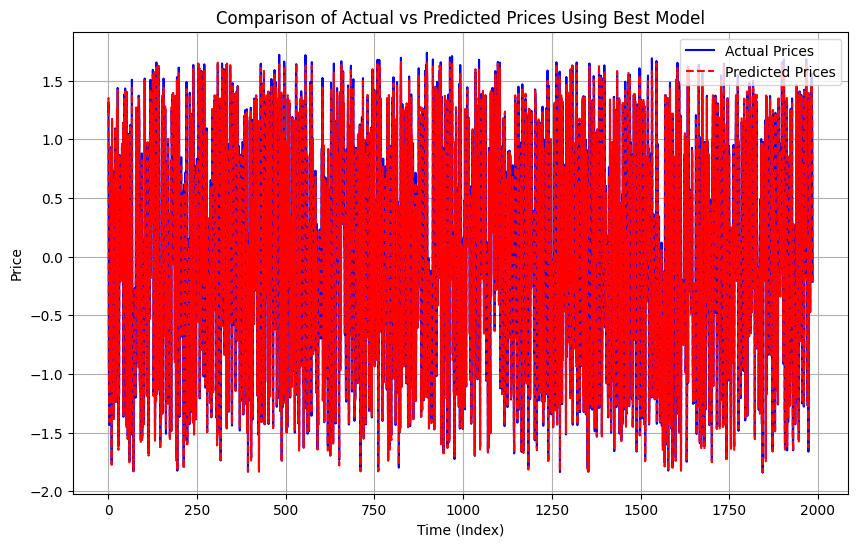

In [ ]:
import matplotlib.pyplot as plt

best_lstm_units = 128
best_learning_rate = 0.001
best_dropout_rate = 0.1

# Build and train the model with the best parameters
best_model = build_model(sequence_length, features_dim, best_lstm_units, best_learning_rate, best_dropout_rate)
best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Predicting the prices
best_predictions = best_model.predict(X_test)
best_actuals = y_test

# Plot
plt.figure(figsize=(10, 6))
plt.plot(best_actuals, label='Actual Prices', color='blue')
plt.plot(best_predictions, label='Predicted Prices', color='red', linestyle='--')
plt.title('Comparison of Actual vs Predicted Prices Using Best Model')
plt.xlabel('Time (Index)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


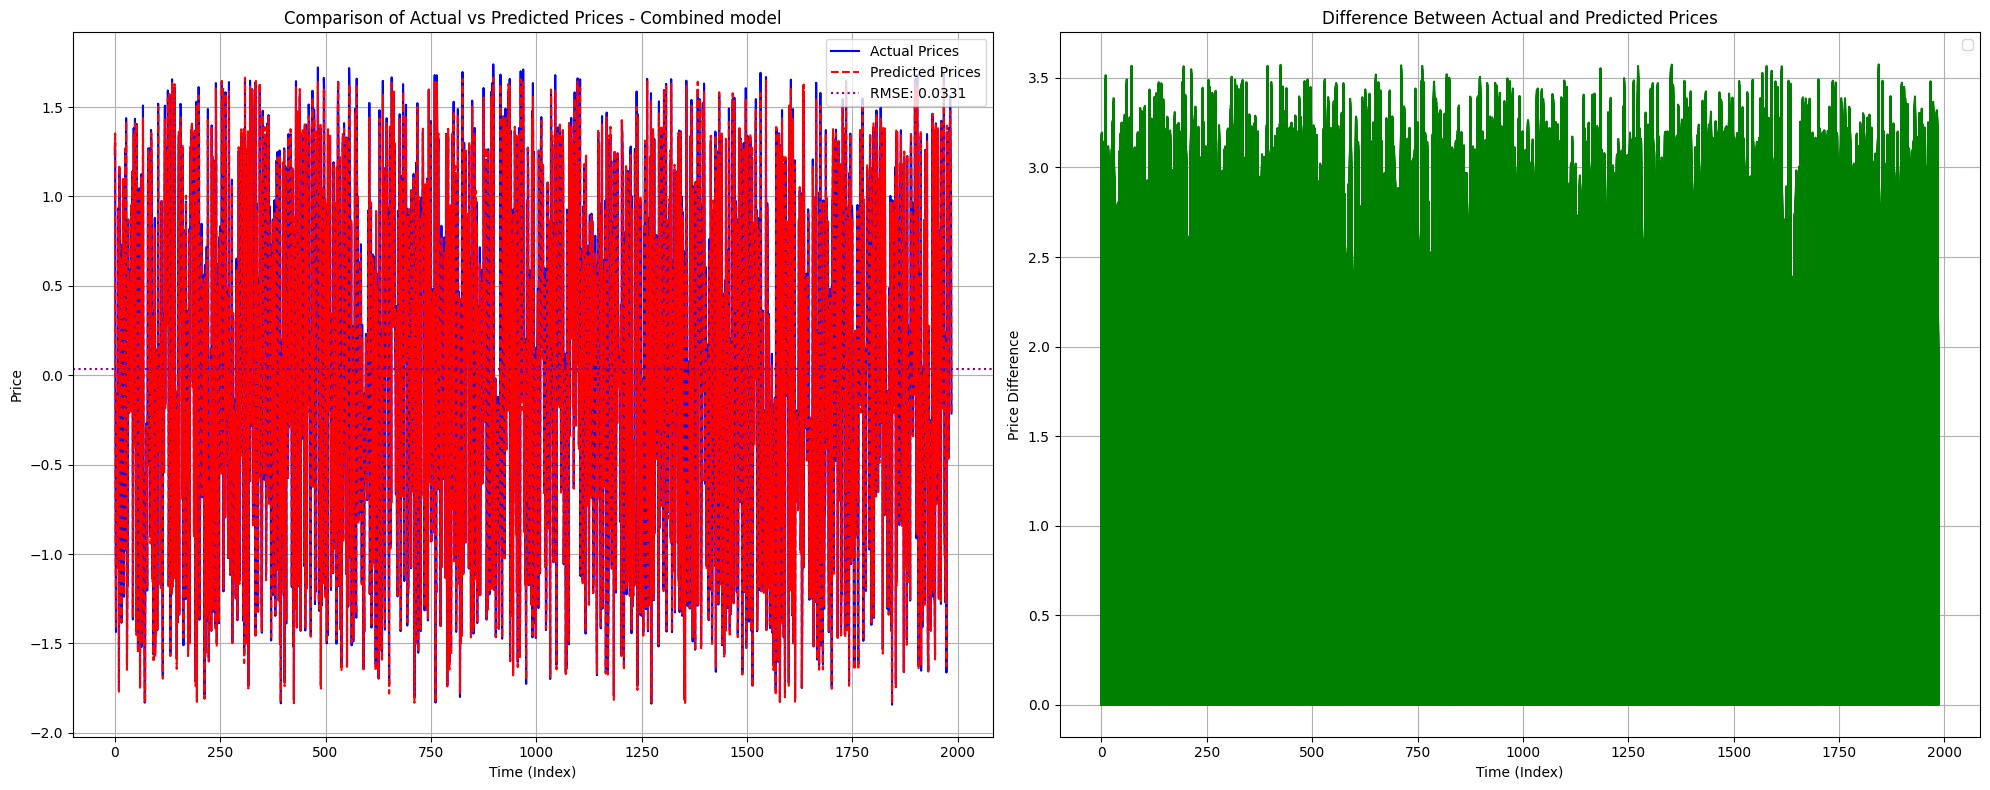

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# First subplot: Actual vs. Predicted Prices
axes[0].plot(best_actuals, label='Actual Prices', color='blue')
axes[0].plot(best_predictions, label='Predicted Prices', color='red', linestyle='--')
axes[0].set_title('Comparison of Actual vs Predicted Prices - Combined model')
axes[0].set_xlabel('Time (Index)')
axes[0].set_ylabel('Price')
# Calculate the differences
differences = np.abs(np.array(best_actuals) - np.array(best_predictions))
rmse = np.sqrt(mean_squared_error(best_actuals, best_predictions))
axes[0].axhline(y=rmse, color='purple', linestyle=':', label=f'RMSE: {rmse:.4f}')
axes[0].legend()
axes[0].grid(True)


# Second subplot: Difference between Actual and Predicted Prices
axes[1].plot(differences, color='green')
axes[1].set_title('Difference Between Actual and Predicted Prices')
axes[1].set_xlabel('Time (Index)')
axes[1].set_ylabel('Price Difference')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# IV. Cross-validation

### Time series cross validation

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

n_splits = 5
window_size = len(X_train) // n_splits

best_lstm_units = 128
best_learning_rate = 0.001
best_dropout_rate = 0.1

for i in range(n_splits):
    split_point = (i + 1) * window_size
    X_train_cv, X_val_cv = X_train[:split_point], X_train[split_point:split_point+window_size]
    y_train_cv, y_val_cv = y_train[:split_point], y_train[split_point:split_point+window_size]

    model = build_model(sequence_length, features_dim, best_lstm_units, best_learning_rate, best_dropout_rate)
    model.fit(X_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred_cv = model.predict(X_val_cv)
    score = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    print(f"Fold {i+1}, RMSE: {score}")

Epoch 1/100
25/25 [==============================] - 4s 7ms/step - loss: 2.5478
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.1544
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0923
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0696
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0740
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0565
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0375
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0412
Epoch 10/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0290
Epoch 11/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 12/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0185
Epoch 13/100
25/25 [=================

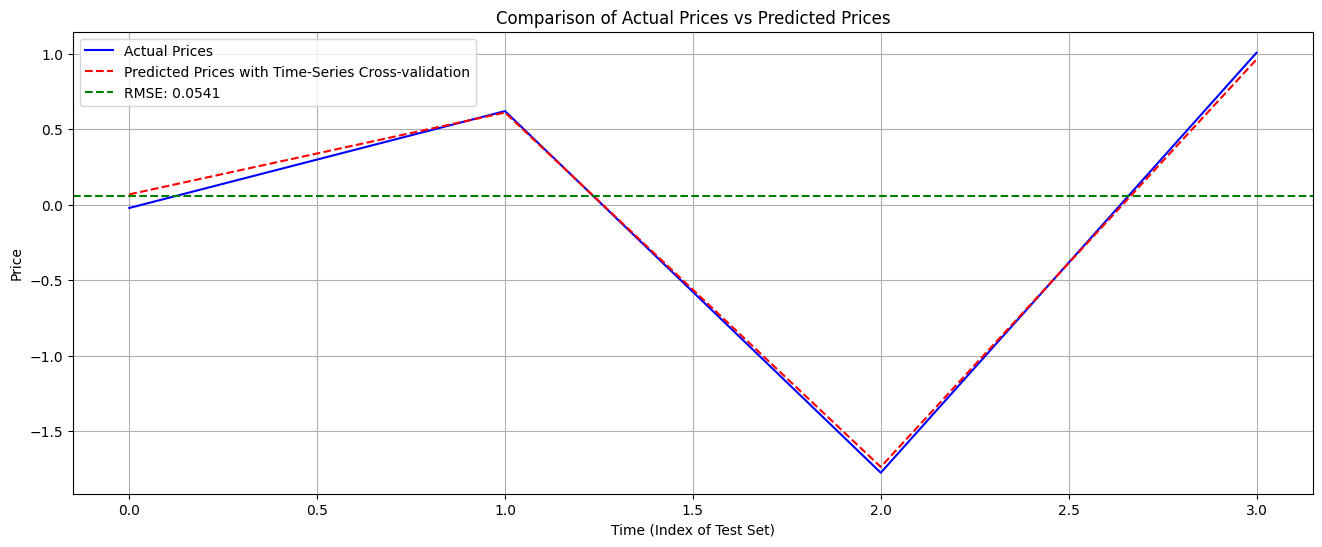

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(y_val_cv, label='Actual Prices', color='blue')  # Actual prices
plt.plot(y_pred_cv, label='Predicted Prices with Time-Series Cross-validation', color='red', linestyle='--')  # Predicted prices
rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
plt.axhline(y=rmse_cv, color='green', linestyle='--', label=f'RMSE: {rmse_cv:.4f}')
plt.title('Comparison of Actual Prices vs Predicted Prices')
plt.xlabel('Time (Index of Test Set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Walk-Forward Validation

In [ ]:
initial_train_size = len(X_train) // 2
window_size = len(X_train) // n_splits  # Increment size

for i in range(0, len(X_train) - initial_train_size, window_size):
    X_train_wf, X_val_wf = X_train[:initial_train_size + i], X_train[initial_train_size + i:initial_train_size + i + window_size]
    y_train_wf, y_val_wf = y_train[:initial_train_size + i], y_train[initial_train_size + i:initial_train_size + i + window_size]

    model = build_model(sequence_length, features_dim, best_lstm_units, best_learning_rate, best_dropout_rate)
    model.fit(X_train_wf, y_train_wf, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred_wf = model.predict(X_val_wf)
    score = np.sqrt(mean_squared_error(y_val_wf, y_pred_wf))
    print(f"Step {i//window_size + 1}, RMSE: {score}")

Epoch 1/100
63/63 [==============================] - 4s 7ms/step - loss: 0.6857
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0887
Epoch 3/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0522
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0278
Epoch 5/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0239
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 7/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0233
Epoch 8/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0113
Epoch 9/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 10/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 11/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 12/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 13/100
63/63 [=================

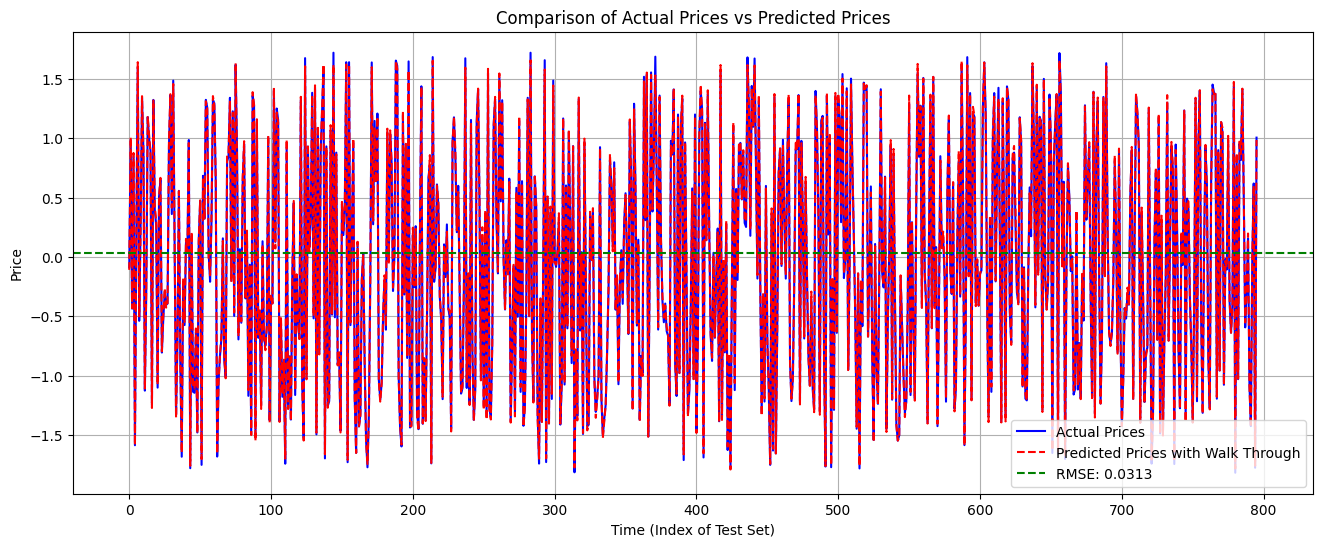

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(y_val_wf, label='Actual Prices', color='blue')  # Actual prices
plt.plot(y_pred_wf, label='Predicted Prices with Walk Through', color='red', linestyle='--')  # Predicted prices
rmse_wf = np.sqrt(mean_squared_error(y_val_wf, y_pred_wf))
plt.axhline(y=rmse_wf, color='green', linestyle='--', label=f'RMSE: {rmse_wf:.4f}')
plt.title('Comparison of Actual Prices vs Predicted Prices')
plt.xlabel('Time (Index of Test Set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Bootstrapping

In [ ]:
from sklearn.utils import resample

n_bootstraps = 5
block_size = 30  # Length of the time series block

for i in range(n_bootstraps):
    indices = np.arange(len(X_train))
    resampled_indices = resample(indices, replace=True, n_samples=len(X_train), random_state=i)
    X_train_bs, y_train_bs = X_train[resampled_indices], y_train[resampled_indices]

    model = build_model(sequence_length, features_dim, best_lstm_units, best_learning_rate, best_dropout_rate)
    model.fit(X_train_bs, y_train_bs, epochs=epochs, batch_size=batch_size, verbose=1)
    y_pred_bs = model.predict(X_test)  # Testing on the original test set
    score = np.sqrt(mean_squared_error(y_test, y_pred_bs))
    print(f"Bootstrap {i+1}, RMSE: {score}")

Epoch 1/100
125/125 [==============================] - 5s 7ms/step - loss: 0.5281
Epoch 2/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0528
Epoch 3/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0236
Epoch 4/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0151
Epoch 5/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0121
Epoch 6/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0120
Epoch 7/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0105
Epoch 8/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0081
Epoch 9/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0111
Epoch 10/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 11/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0066
Epoch 12/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0081
Epoch 13/100


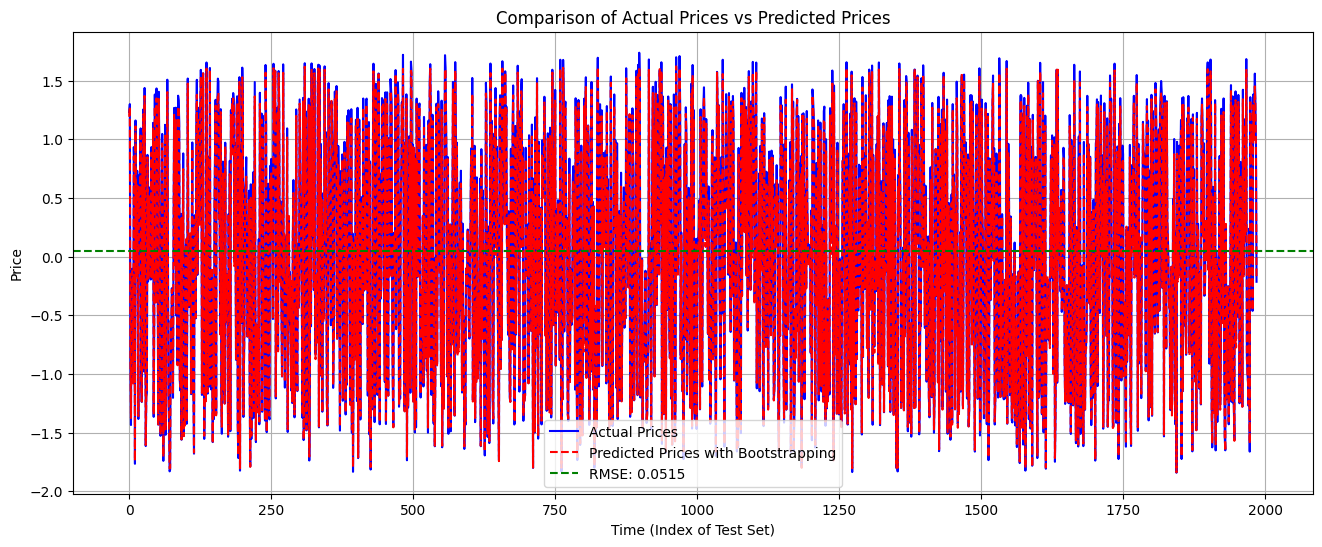

In [ ]:
# Plotting
plt.figure(figsize=(16, 6))
plt.plot(y_test, label='Actual Prices', color='blue')  # Actual prices
plt.plot(y_pred_bs, label='Predicted Prices with Bootstrapping', color='red', linestyle='--')  # Predicted prices
rmse_bs = np.sqrt(mean_squared_error(y_test, y_pred_bs))
plt.axhline(y=rmse_bs, color='green', linestyle='--', label=f'RMSE: {rmse_bs:.4f}')
plt.title('Comparison of Actual Prices vs Predicted Prices')
plt.xlabel('Time (Index of Test Set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

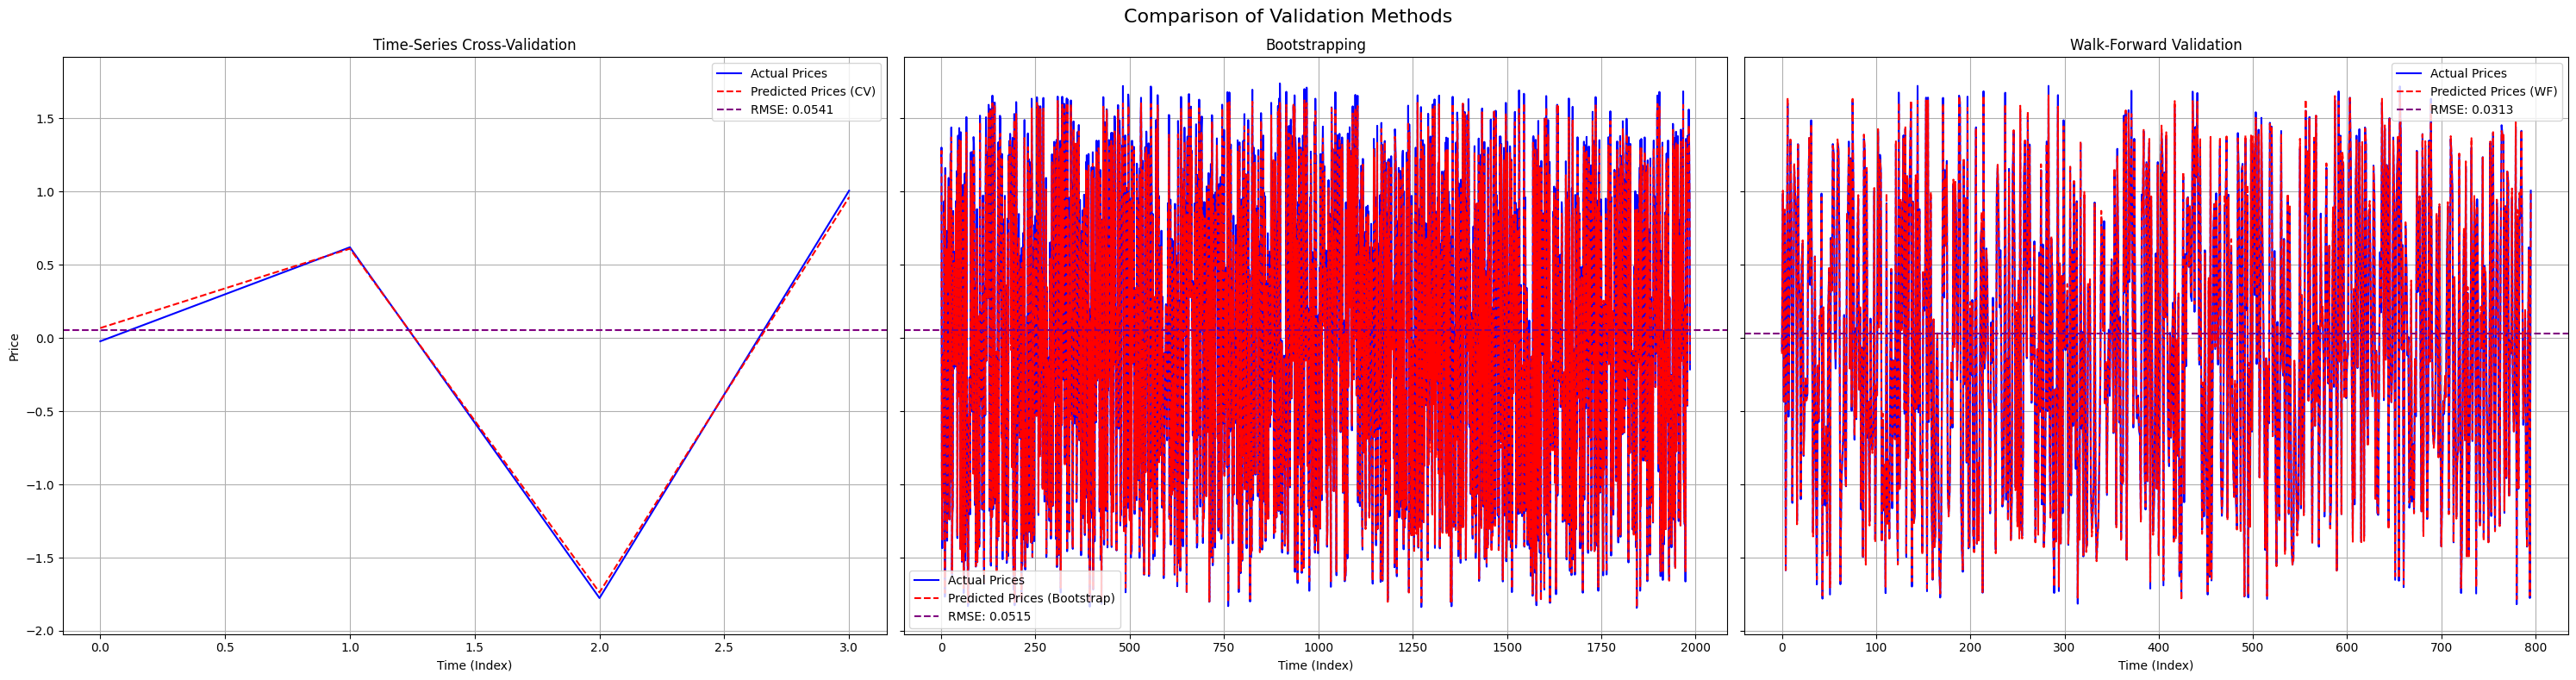

In [ ]:
#COMBINING THE PLOTS
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8), sharey=True)

# Time-Series Cross-Validation Plot
axes[0].plot(y_val_cv, label='Actual Prices', color='blue')
axes[0].plot(y_pred_cv, label='Predicted Prices (CV)', color='red', linestyle='--')
axes[0].axhline(y=rmse_cv, color='purple', linestyle='--', label=f'RMSE: {rmse_cv:.4f}')
axes[0].set_title('Time-Series Cross-Validation')
axes[0].set_xlabel('Time (Index)')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Bootstrapping Plot
axes[1].plot(y_test, label='Actual Prices', color='blue')  # Assuming y_test is correct here
axes[1].plot(y_pred_bs, label='Predicted Prices (Bootstrap)', color='red', linestyle='--')
axes[1].axhline(y=rmse_bs, color='purple', linestyle='--', label=f'RMSE: {rmse_bs:.4f}')
axes[1].set_title('Bootstrapping')
axes[1].set_xlabel('Time (Index)')
axes[1].legend()
axes[1].grid(True)

# Walk-Forward Validation Plot
axes[2].plot(y_val_wf, label='Actual Prices', color='blue')
axes[2].plot(y_pred_wf, label='Predicted Prices (WF)', color='red', linestyle='--')
axes[2].axhline(y=rmse_wf, color='purple', linestyle='--', label=f'RMSE: {rmse_wf:.4f}')
axes[2].set_title('Walk-Forward Validation')
axes[2].set_xlabel('Time (Index)')
axes[2].legend()
axes[2].grid(True)

fig.suptitle('Comparison of Validation Methods', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Combine parameter optimization with time series cross-validation

In [ ]:
n_splits = 5
window_size = len(X_train) // (n_splits + 1)

learning_rates = [0.0001, 0.001, 0.01]
dropout_rates = [0, 0.1, 0.2]
best_score = np.inf
best_params = {}
best_predictions_cs = None
best_actuals_cs = None

for lr in learning_rates:
    for dr in dropout_rates:
        scores = []
        predictions = []
        actuals = []

        for i in range(n_splits):
            split_point = window_size * (i + 1)
            X_train_cv, X_test_cv = X_train[:split_point], X_train[split_point:split_point + window_size]
            y_train_cv, y_test_cv = y_train[:split_point], y_train[split_point:split_point + window_size]

            model = build_model(sequence_length, features_dim, best_lstm_units, best_learning_rate, best_dropout_rate)
            model.fit(X_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size, verbose=1)
            y_pred_cv = model.predict(X_test_cv)
            score = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
            scores.append(score)

            # Collect all predictions and actuals for later analysis
            predictions.append(y_pred_cv.flatten())
            actuals.append(y_test_cv.flatten())

        average_score = np.mean(scores)
        print(f"LR: {lr}, DR: {dr}, Avg Test RMSE: {average_score}")

        if average_score < best_score:
            best_score = average_score
            best_params = {'learning_rate': lr, 'dropout_rate': dr}
            # Update best predictions and actual labels
            best_predictions_cs = np.concatenate(predictions)
            best_actuals_cs = np.concatenate(actuals)

print("Best Score (RMSE):", best_score)
print("Best Parameters:", best_params)


Streaming output truncated to the last 5000 lines.
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 18/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 19/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 20/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0205
Epoch 21/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 22/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 23/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 24/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 25/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 26/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0115
Epoch 27/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 28/100
21/21 [==============================] - 0s 8

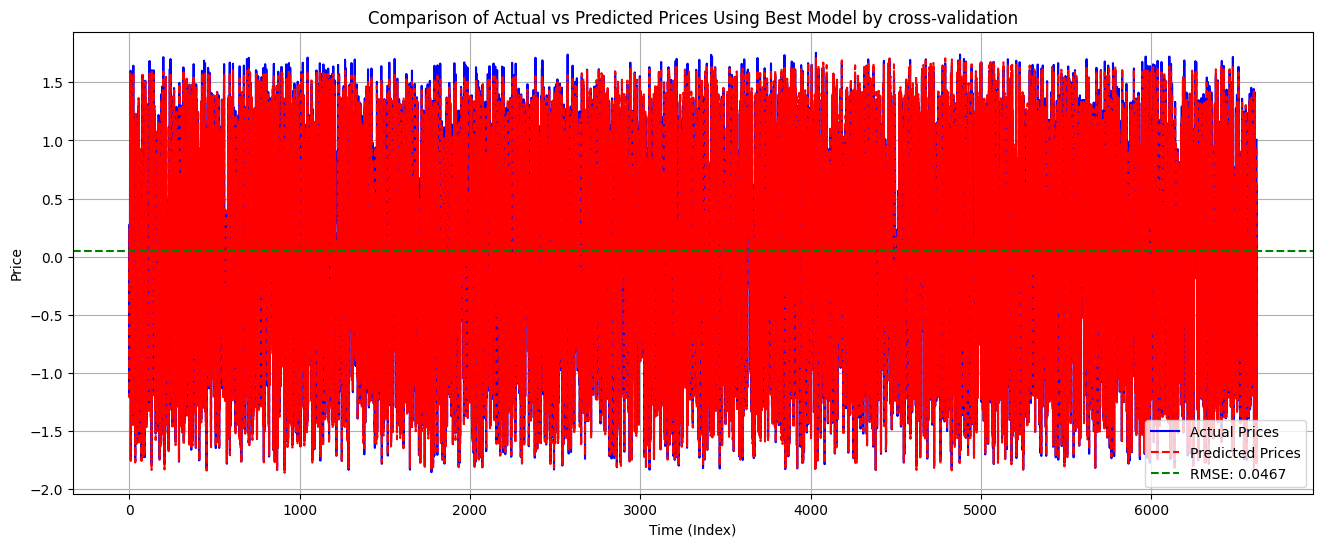

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(best_actuals_cs, label='Actual Prices', color='blue')
plt.plot(best_predictions_cs, label='Predicted Prices', color='red', linestyle='--')
rmse_b_cs = np.sqrt(mean_squared_error(best_actuals_cs, best_predictions_cs))
plt.axhline(y=rmse_b_cs, color='green', linestyle='--', label=f'RMSE: {rmse_b_cs:.4f}')
plt.title('Comparison of Actual vs Predicted Prices Using Best Model by cross-validation')
plt.xlabel('Time (Index)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Combine parameter optimization with bootstrapping

In [ ]:
n_bootstraps = 5
block_size = 31  # Length of the time series block

learning_rates = [0.0001, 0.001, 0.01]
dropout_rates = [0, 0.1, 0.2]
best_score = np.inf
best_params = {}
best_predictions_bs = None
best_actuals_bs = None

for lr in learning_rates:
    for dr in dropout_rates:
        scores = []

        for i in range(n_bootstraps):
            indices = np.random.choice(range(len(X_train) - block_size + 1), size=len(X_train) // block_size, replace=True)
            X_train_bs = np.concatenate([X_train[idx:idx + block_size] for idx in indices])
            y_train_bs = np.concatenate([y_train[idx:idx + block_size] for idx in indices])

            model = build_model(sequence_length, features_dim, best_lstm_units, best_learning_rate, best_dropout_rate)
            model.fit(X_train_bs, y_train_bs, epochs=epochs, batch_size=batch_size, verbose=1)
            y_pred_bs = model.predict(X_test)
            score = np.sqrt(mean_squared_error(y_test, y_pred_bs))
            scores.append(score)

        average_score = np.mean(scores)
        print(f"LR: {lr}, DR: {dr}, Avg Test RMSE: {average_score}")

        if average_score < best_score:
            best_score = average_score
            best_params = {'learning_rate': lr, 'dropout_rate': dr}
            # Update best predictions and actual labels
            best_predictions_bs = y_pred_bs
            best_actuals_bs = y_test  # Assuming y_test is your actual labels

print("Best Score (RMSE):", best_score)
print("Best Parameters:", best_params)


Streaming output truncated to the last 5000 lines.
Epoch 17/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0054
Epoch 18/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0053
Epoch 19/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 20/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0037
Epoch 21/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0046
Epoch 22/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0049
Epoch 23/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0042
Epoch 24/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0033
Epoch 25/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0028
Epoch 26/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0035
Epoch 27/100
124/124 [==============================] - 1s 6ms/step - loss: 0.0026
Epoch 28/100
124/124 [==============

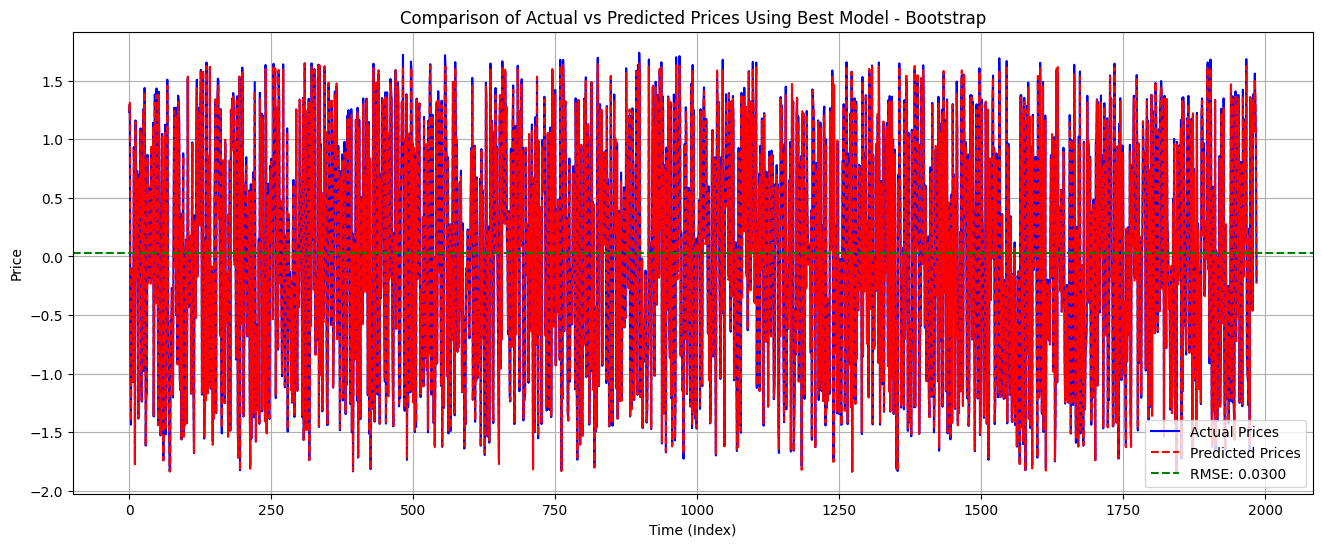

In [ ]:
# Plotting the results of the best model
plt.figure(figsize=(16, 6))
plt.plot(best_actuals_bs, label='Actual Prices', color='blue')
plt.plot(best_predictions_bs, label='Predicted Prices', color='red', linestyle='--')
rmse_b_bs = np.sqrt(mean_squared_error(best_actuals_bs, best_predictions_bs))
plt.axhline(y=rmse_b_bs, color='green', linestyle='--', label=f'RMSE: {rmse_b_bs:.4f}')
plt.title('Comparison of Actual vs Predicted Prices Using Best Model - Bootstrap')
plt.xlabel('Time (Index)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


### Combine parameter optimization with walk through validation

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Constants
initial_train_size = len(X_train) // 2
step_size = window_size  # Increment size for each step

learning_rates = [0.0001, 0.001, 0.01]
dropout_rates = [0, 0.1, 0.2]
best_score = np.inf
best_params = {}
best_predictions_wf = None
best_actuals_wf = None

for lr in learning_rates:
    for dr in dropout_rates:
        scores = []
        all_predictions = []
        all_actuals = []

        for i in range(0, len(X_train) - initial_train_size, step_size):
            X_train_wf, X_val_wf = X_train[:initial_train_size + i], X_train[initial_train_size + i:initial_train_size + i + step_size]
            y_train_wf, y_val_wf = y_train[:initial_train_size + i], y_train[initial_train_size + i:initial_train_size + i + step_size]

            model = build_model(sequence_length, features_dim, best_lstm_units, best_learning_rate, best_dropout_rate)
            model.fit(X_train_wf, y_train_wf, epochs=epochs, batch_size=batch_size, verbose=1)
            y_pred_wf = model.predict(X_val_wf)
            score = np.sqrt(mean_squared_error(y_val_wf, y_pred_wf))
            scores.append(score)
            all_predictions.extend(y_pred_wf.flatten())
            all_actuals.extend(y_val_wf.flatten())

        average_score = np.mean(scores)
        print(f"LR: {lr}, DR: {dr}, Avg Test RMSE: {average_score}")

        if average_score < best_score:
            best_score = average_score
            best_params = {'learning_rate': lr, 'dropout_rate': dr}
            best_predictions_wf = np.array(all_predictions)
            best_actuals_wf = np.array(all_actuals)

print("Best Score (RMSE):", best_score)
print("Best Parameters:", best_params)


Streaming output truncated to the last 5000 lines.
Epoch 19/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0046
Epoch 20/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 21/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0030
Epoch 22/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0028
Epoch 23/100
104/104 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 24/100
104/104 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 25/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0025
Epoch 26/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 27/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 28/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0028
Epoch 29/100
104/104 [==============================] - 1s 7ms/step - loss: 0.0028
Epoch 30/100
104/104 [==============

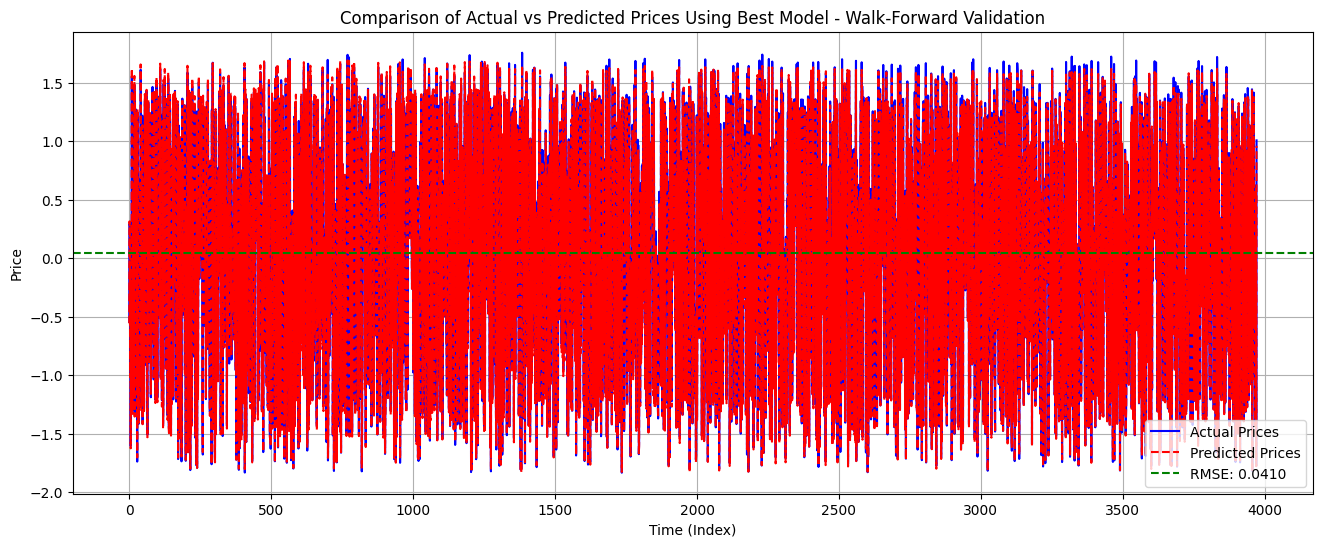

In [ ]:
# Plotting the results of the best model
plt.figure(figsize=(16, 6))
plt.plot(best_actuals_wf, label='Actual Prices', color='blue')
plt.plot(best_predictions_wf, label='Predicted Prices', color='red', linestyle='--')
rmse_b_wf = np.sqrt(mean_squared_error(best_actuals_wf, best_predictions_wf))
plt.axhline(y=rmse_b_wf, color='green', linestyle='--', label=f'RMSE: {rmse_b_wf:.4f}')
plt.title('Comparison of Actual vs Predicted Prices Using Best Model - Walk-Forward Validation')
plt.xlabel('Time (Index)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

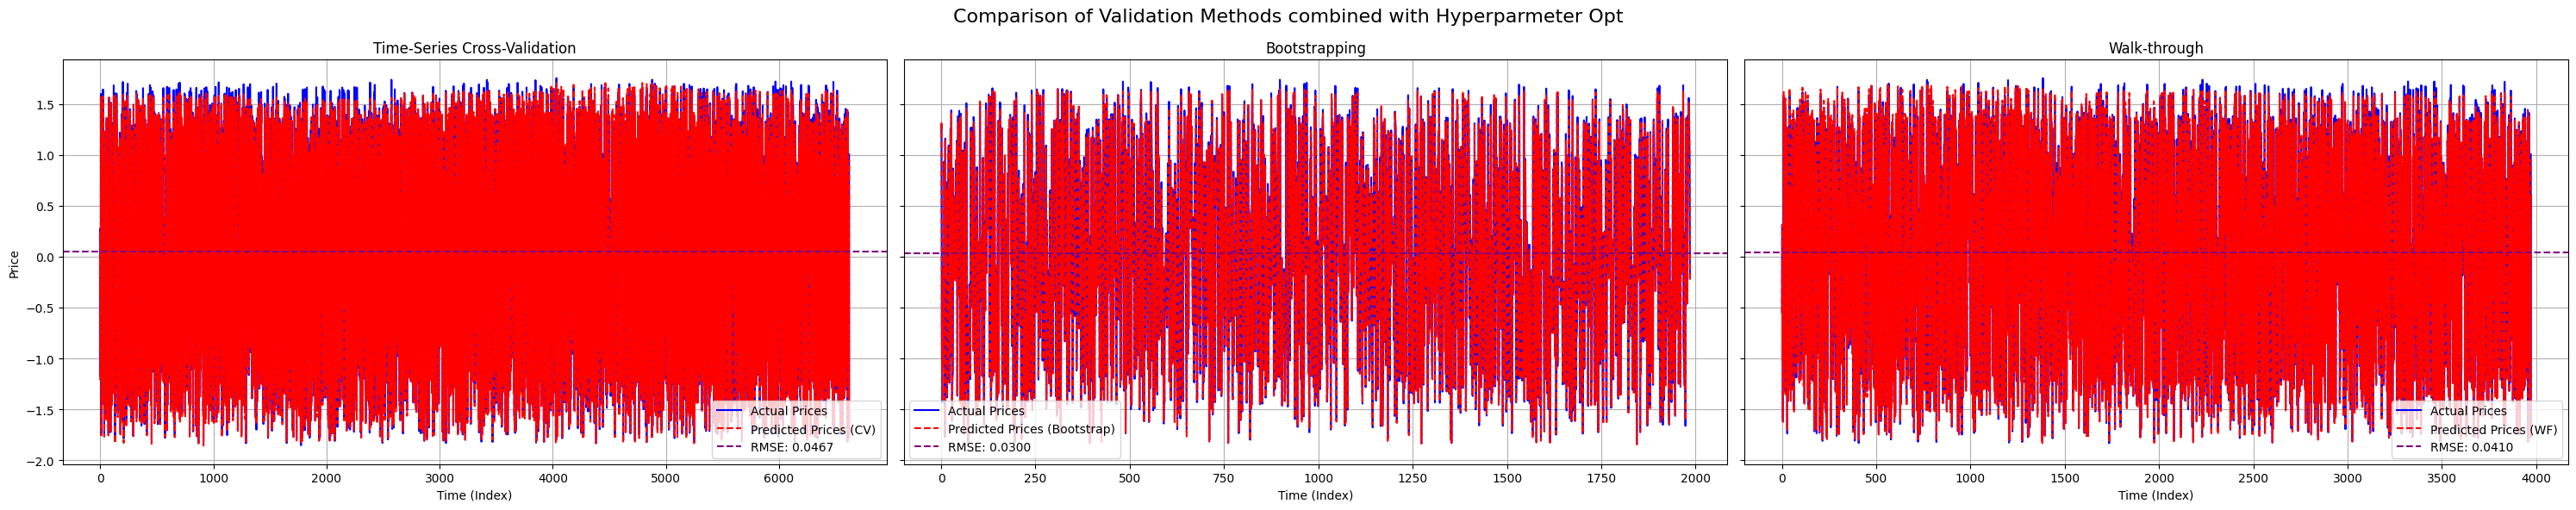

In [ ]:
#COMBINING THE PLOTS
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 6), sharey=True)

# Time-Series Cross-Validation Plot
axes[0].plot(best_actuals_cs, label='Actual Prices', color='blue')
axes[0].plot(best_predictions_cs, label='Predicted Prices (CV)', color='red', linestyle='--')
axes[0].axhline(y=rmse_b_cs, color='purple', linestyle='--', label=f'RMSE: {rmse_b_cs:.4f}')
axes[0].set_title('Time-Series Cross-Validation')
axes[0].set_xlabel('Time (Index)')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Bootstrapping Plot
axes[1].plot(best_actuals_bs, label='Actual Prices', color='blue')  # Assuming y_test is correct here
axes[1].plot(best_predictions_bs, label='Predicted Prices (Bootstrap)', color='red', linestyle='--')
axes[1].axhline(y=rmse_b_bs, color='purple', linestyle='--', label=f'RMSE: {rmse_b_bs:.4f}')
axes[1].set_title('Bootstrapping')
axes[1].set_xlabel('Time (Index)')
axes[1].legend()
axes[1].grid(True)

# Walk-Forward Validation Plot
axes[2].plot(best_actuals_wf, label='Actual Prices', color='blue')
axes[2].plot(best_predictions_wf, label='Predicted Prices (WF)', color='red', linestyle='--')
axes[2].axhline(y=rmse_b_wf, color='purple', linestyle='--', label=f'RMSE: {rmse_b_wf:.4f}')
axes[2].set_title('Walk-through')
axes[2].set_xlabel('Time (Index)')
axes[2].legend()
axes[2].grid(True)

fig.suptitle('Comparison of Validation Methods combined with Hyperparmeter Opt', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()